## Cleaning the CO2 data columns

### Setup

In [7]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np

from utils import data_loader

### Getting the data

In [6]:
flight_data = pd.read_csv("../Project/flight_data.csv")
flight_data.head()

,from_airport_code,from_country,dest_airport_code,dest_country,aircraft_type,airline_number,airline_name,flight_number,departure_time,arrival_time,duration,stops,price,currency,co2_emissions,avg_co2_emission_for_this_route,co2_percentage,scan_date
0,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Airbus A330|Airbu...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1320000.0,1320000.0,0%,2022-04-29 17:52:59
1,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Boeing 787|Airbus...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1195000.0,1320000.0,-9%,2022-04-29 17:52:59
2,ALG,Algeria,AEP,Argentina,Airbus A320|Airbus A321|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1855|AF1855|AF1855|AF1855,2022-04-30 12:45:00,2022-05-01 10:15:00,1530,3,1284.0,USD,1248000.0,1320000.0,-5%,2022-04-29 17:52:59
3,ALG,Algeria,AEP,Argentina,Airbus A318|Airbus A320|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1290.0,USD,1347000.0,1320000.0,2%,2022-04-29 17:52:59
4,ALG,Algeria,AEP,Argentina,Airbus A321neo|Boeing 777|Airbus A320,multi,[Lufthansa| LATAM],LH1317|LH1317|LH1317,2022-04-30 12:35:00,2022-05-01 10:15:00,1540,2,1347.0,USD,1381000.0,1320000.0,4%,2022-04-29 17:52:59


### Cleaning

Since the documentation of the data is not great, the CO2 columns (co2_emissions, avg_co2_emission_for_this_route and co2_percentage) are not really usefull. They have no unit and the averages and percentages are not clear on how they were calculated.

To use the columns we will normalize the co2_emissions column:

$z_{i}=\frac{x_{i}-min(x)}{max(x)-min(x)}$

$z_{i}$ is the i'th normalized value, $x_{i}$ is the i'th observed value, $min(x)$ is the minimum and $max(x)$ is the maximum for all $x$ observations.

##### co2_emissions before

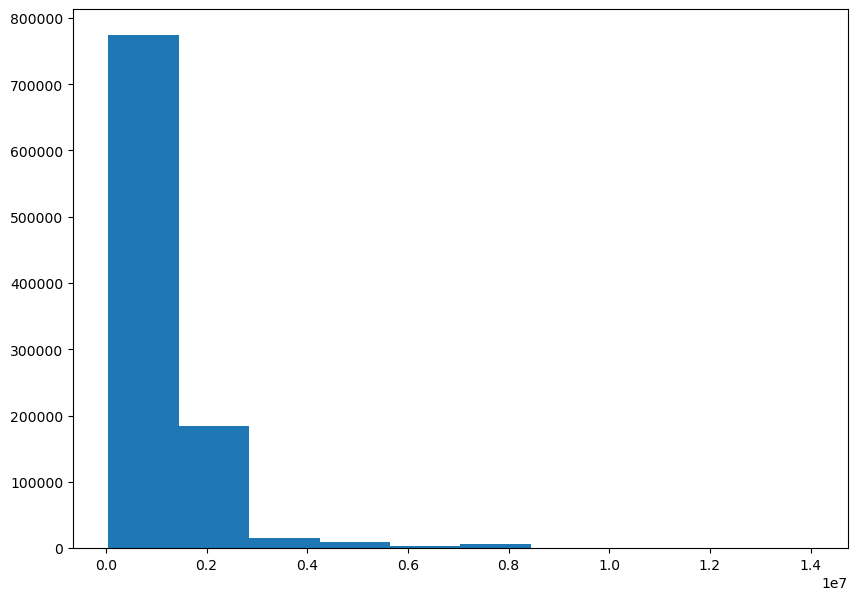

In [25]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(flight_data["co2_emissions"])
plt.show()

##### Normalize co2_emissions

In [26]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())

flight_data["co2_emissions"] = min_max_scaling(flight_data["co2_emissions"])

  from_airport_code from_country dest_airport_code dest_country  \
0               ALG      Algeria               AEP    Argentina   
1               ALG      Algeria               AEP    Argentina   
2               ALG      Algeria               AEP    Argentina   
3               ALG      Algeria               AEP    Argentina   
4               ALG      Algeria               AEP    Argentina   

                                       aircraft_type airline_number  \
0  Airbus A318|Canadair RJ 1000|Airbus A330|Airbu...          multi   
1  Airbus A318|Canadair RJ 1000|Boeing 787|Airbus...          multi   
2     Airbus A320|Airbus A321|Boeing 787|Airbus A320          multi   
3     Airbus A318|Airbus A320|Boeing 787|Airbus A320          multi   
4              Airbus A321neo|Boeing 777|Airbus A320          multi   

                  airline_name                flight_number  \
0  [Air France| Iberia| LATAM]  AF1491|AF1491|AF1491|AF1491   
1  [Air France| Iberia| LATAM]  AF1491|AF149

#### co2_emissions after

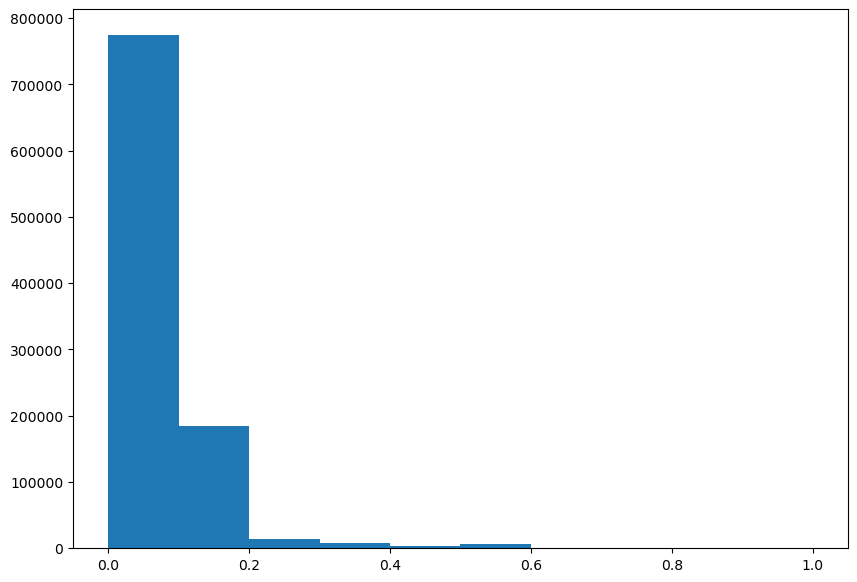

In [27]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(flight_data["co2_emissions"])
plt.show()

The histograms look the same, with the exception of the x-axis now being between values of 0 and 1. This indicates that the normalization has worked. We can now move on to the avg_co2_emission_for_this_route, where we want to find an average for each combination of from_airport_code and dest_airport_code, averaging the values in each group.

In [39]:
groups = flight_data.groupby(["from_airport_code", "dest_airport_code"])["co2_emissions"].mean()

from_airport_code  dest_airport_code
ADD                AEP                  0.127204
                   ALG                  0.058008
                   AMS                  0.048971
                   ARN                  0.046727
                   ATH                  0.044391
                                          ...   
YYZ                TPE                  0.115010
                   VCP                  0.077961
                   VIE                  0.053523
                   XIY                  0.126325
                   ZRH                  0.050169
Name: co2_emissions, Length: 2268, dtype: float64


In [69]:
for index, row in flight_data.iterrows():
    flight_data.at[index, "avg_co2_emission_for_this_route"] = groups[row["from_airport_code"]][row["dest_airport_code"]]

For each route an average of the normalized function can be used as a value for avg_co2_emission_for_this_route. The difference between the average and the route can be calculated as a percentage and be the value for a new co2_percentage column.

In [71]:
for index, row in flight_data.iterrows():
    flight_data.at[index, "co2_percentage"] = ((row["avg_co2_emission_for_this_route"] - row["co2_emissions"])/row["avg_co2_emission_for_this_route"])